In [ ]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

# Advanced Path Tracing

Differt provides both high-level and low-level interface to Path Tracing.

This tutorial provides a quick tour of what you can do with the **lower-level** API,
and the logic used to perform Ray Tracing.

## Example on a simple scene

Before diving into a complex scene, this is worth using a very simple scene first.

### Necessary imports

Because we are going for the lower-level way, we will need quite a few imports.

In [2]:
import jax.numpy as jnp
import numpy as np

import differt.plotting as dplt
from differt.geometry import TriangleMesh
from differt.geometry.triangle_mesh import (
    triangles_contain_vertices_assuming_inside_same_plane,
)
from differt.geometry.utils import assemble_paths
from differt.rt.image_method import (
    consecutive_vertices_are_on_same_side_of_mirrors,
    image_method,
)
from differt.rt.utils import (
    generate_all_path_candidates,
    rays_intersect_triangles,
)

### Loading a mesh

For each type of supported meshes, we provide some utilities
to load a mesh from a file.

In [3]:
mesh_file = "two_buildings.obj"  # Very simple scene with two buildings
mesh = TriangleMesh.load_obj(mesh_file)

### Plotting your setup

Here, we will use Plotly as the plotting backend, because it renders very nicely, especially on the web.
On larger scenes, you will likely need something more performant, like Vispy, see [Choosing your plotting backend](plotting_backend.ipynb#choosing-your-plotting-backend).

In [4]:
dplt.set_defaults("plotly")  # Let's use the Plotly backend

fig = mesh.plot(opacity=0.5)
fig

Ray Tracing without start and end points is not very interesting.
Let's add one transmitter and one receiver in the scene, represented by their 3D coordinates.

In [5]:
tx = jnp.array([0.0, 4.9352, 22.0])
rx = jnp.array([0.0, 10.034, 1.50])

dplt.draw_markers(
    np.array([tx, rx]), labels=["tx", "rx"], figure=fig, name="nodes"
)

### How we trace rays

Ray Tracing can be implemented in many ways, depending on the desired performances, the level of accuracy needed,
or the representation of the geometry.

Here, we will implement deterministic (or exact) Ray Tracing. That is, we want to generate all possible paths from TX to RX, that undergo up to a maximum number of interactions with the environment. Interactions can be reflections, diffractions, etc.

One way to generate all possible paths is to represent the problem as a graph. Then, the goal is to find all the paths from the node corresponding to TX, to the node corresponding to RX, while possibly visiting intermediate nodes in the graph, where each corresponds to a specific primitive in the scene (here, a triangle).

A graph algorithm will therefore generate a list of *path candidates*. We use the word *candidate* to emphasize that this is not a real path (i.e., not 3D coordinates), but only an ordered list of nodes to visit, for a given path.

Then, this is the role of the **path finding** method (e.g., {func}`image_method<differt.rt.image_method.image_method>` or {func}`fermat_path_on_planar_mirrors<differt.rt.fermat.fermat_path_on_planar_mirrors>`) to find the exact coordinates of that path.

Let's select a subset of our primitives to understand what we have just talked about.

In [6]:
select = [
    8,  # Red
    9,  # Red
    22,  # Green
    23,  # Green
]  # Ideally, you will never hard-code the primitive indices yourself

vertices = mesh.vertices
triangles = mesh.triangles[select, :]

dplt.draw_mesh(vertices, triangles[:2, :], figure=fig, color="red")
dplt.draw_mesh(vertices, triangles[2:, :], figure=fig, color="green")

Looking at the above, we can clearly see that a line-of-sight (LOS) path between TX and RX exists.

With a bit of thinking, we could also imagine that a path with one or more reflections might join TX and RX.

For example, <kbd>TX -> Red surface -> RX</kbd> might probably produce a valid path.
The same logic can be applied to <kbd>TX -> Red surface -> Green surface -> RX</kbd>.

In [7]:
# A list of color to easily differentiate paths
color = ["black", "green", "orange", "yellow", "blue"]

select = jnp.array(
    select[::2],
    dtype=int,
)  # We actually only need one triangle per plane, so [8, 22]

# Iterate through path candidates
#
#                         ┌> order 0
#                         |           ┌> order 1
#                         |           |           ┌> order 2
for path_candidate in [select[:0], select[:1], select[:2]]:
    # 1 - Prepare input arrays
    from_vertices = tx
    to_vertices = rx
    mirror_vertices = mesh.vertices[mesh.triangles[path_candidate, 0], :]
    mirror_normals = mesh.normals[path_candidate, :]

    # 2 - Trace paths

    path = image_method(
        from_vertices, to_vertices, mirror_vertices, mirror_normals
    )

    # 3 - ??

    # 4 - Obtain final valid paths and plot

    # The full path is [tx, paths, rx]
    full_path = jnp.concatenate(
        (
            from_vertices[None, :],
            path,
            to_vertices[None, :],
        ),
    )

    # The we plot it
    dplt.draw_paths(
        full_path,
        figure=fig,
        marker={
            "size": 0,
            "color": "black",
        },
        line={"color": color[len(path_candidate)], "width": 3},
        name=f"Order {len(path_candidate)}",
    )

fig

Nice! Thanks to the {func}`image_method<differt.rt.image_method.image_method>`, we successfully generated the paths we just mentioned.

### Scaling on more paths and more surfaces

Manually identifying the surfaces of interest and generating all possible path candidates can rapidly become tedious as the number of surfaces or the path order increase.

For this purpose, we created the {func}`generate_all_path_candidates<differt.rt.utils.generate_all_path_candidates>` function. Written in Rust for performance purposes, this function can generate millions of path candidates per second!

This is all nice, but there is one important side-effect of this: if you generate all possible path candidates, how to remove invalid paths that may, e.g., cross a building?

This is where our third step comes into play: we need to validate our path against a series of checks. We can usually identify three types of checks:


1. **Are path coordinates within the boundary of their respective objects?** Manytimes, the objects are assumed to be infinitely long. Then, a check is performed to verify if the solution was found within the object's boundaries;
2. **Are all interactions valid?** E.g., do all reflections occur with an angle of reflection equal to the ange of incidence? Most path tracing methods have some faillible cases where it can return degenerate solutions;
3. **Does any object in the scene obstruct the path?** Usually, the path is first computed without taking the surrounding objects into account, which produce paths that buildings.

A possible implementation of the above rules, applied to the {func}`image_method<differt.rt.image_method.image_method>`, is provided below. A lot of the code is just broadcasting arrays into the right shapes, to benefit from the vectorized computations on arrays, i.e., instead of using *slow* Python for-loops.

In [8]:
fig.data = fig.data[:2]  # Keep only first 2 traces: geometry and TX/RX

# [num_triangles 3 3]
all_triangle_vertices = jnp.take(mesh.vertices, mesh.triangles, axis=0)

num_triangles = mesh.triangles.shape[0]

for order in range(5):
    # 1 - Prepare input arrays

    # [num_path_candidates order]
    path_candidates = generate_all_path_candidates(num_triangles, order)
    num_path_candidates = path_candidates.shape[0]

    # [3]
    from_vertices = tx
    to_vertices = rx

    # [num_path_candidates order 3]
    triangles = jnp.take(mesh.triangles, path_candidates, axis=0)

    # [num_path_candidates order 3 3]
    triangle_vertices = jnp.take(mesh.vertices, triangles, axis=0)

    # [num_path_candidates order 3]
    mirror_vertices = triangle_vertices[
        ...,
        0,
        :,
    ]  # Only one vertex per triangle is needed
    # [num_path_candidates order 3]
    mirror_normals = jnp.take(mesh.normals, path_candidates, axis=0)

    # 2 - Trace paths

    # [num_path_candidates order 3]
    paths = image_method(
        from_vertices, to_vertices, mirror_vertices, mirror_normals
    )

    # 3 - Remove invalid paths

    # 3.1 - Remove paths with vertices outside triangles
    # [num_path_candidates order]
    mask = triangles_contain_vertices_assuming_inside_same_plane(
        triangle_vertices,
        paths,
    )
    # [num_path_candidates]
    mask = jnp.all(mask, axis=-1)

    # [num_paths_inter order+2 3]
    full_paths = assemble_paths(
        from_vertices[None, None, :],
        paths[mask, ...],
        to_vertices[None, None, :],
    )
    # 3.2 - Remove paths with vertices not on the same side of mirrors
    # [num_paths_inter order]
    mask = consecutive_vertices_are_on_same_side_of_mirrors(
        full_paths,
        mirror_vertices[mask, ...],
        mirror_normals[mask, ...],
    )

    # [num_paths_inter]
    mask = jnp.all(mask, axis=-1)  # We will actually remove them later

    # 3.3 - Remove paths that are obstructed by other objects
    # [num_paths_inter order+1 3]
    ray_origins = full_paths[..., :-1, :]
    # [num_paths_inter order+1 3]
    ray_directions = jnp.diff(full_paths, axis=-2)

    # [num_paths_inter order+1 num_triangles], [num_paths_inter order+1 num_triangles]
    t, hit = rays_intersect_triangles(
        ray_origins[..., None, :],
        ray_directions[..., None, :],
        all_triangle_vertices[None, None, ...],
    )
    # In theory, we could do t < 1.0 (because t == 1.0 means we are perfectly on a surface,
    # which is probably desirable, e.g., from a reflection) but in practice numerical
    # errors accumulate and will make this check impossible.
    # [num_paths_inter order+1 num_triangles]
    intersect = (t < 0.999) & hit
    #  [num_paths_inter]
    intersect = jnp.any(intersect, axis=(-1, -2))
    #  [num_paths_inter]
    mask = mask & ~intersect

    # 4 - Obtain final valid paths and plot

    #  [num_paths_final]
    full_paths = full_paths[mask, ...]

    dplt.draw_paths(
        full_paths,
        figure=fig,
        marker={
            "size": 0,
            "color": "black",
        },
        line={"color": color[order], "width": 3},
        name=f"Order {order}",
    )

fig

Another path tracing method that is fully compatible with the above cell is {func}`fermat_path_on_planar_mirrors<differt.rt.fermat.fermat_path_on_planar_mirrors>`. You can safely use the latter instead of the former, and that should produce the same result. Note that the Fermat path tracing is much slower than the Image method, but can be applied to other types of interactions than just pure specular reflection.

## Example on more complex scenes

Most of the code we presented so far scales pretty well on larger scenes. However, there are is notable
exception: {func}`generate_all_path_candidates<differt.rt.utils.generate_all_path_candidates>`.

With a bit of maths[^1], we can determine that a call to `generate_all_path_candidates(num_triangles, order)` generates an array of size $\texttt{num_triangles}(\texttt{num_triangles}-1)^{\texttt{order}-1} \times \texttt{order}$.

On scenes with many triangles, this rapidly becomes too big to fit in memory. To circumvent this issue, we also provide an iterator variant, {func}`generate_all_path_candidates_chunks_iter<differt.rt.utils.generate_all_path_candidates_chunks_iter>`, that produces arrays of a smaller size, defined by the `chunk_size` argument.

While this offers a solution to the memory allocation issue, this does not reduce the number of path candidates. To reduce this number, you somehow need to prune a subset of the path candidates before you actually generate them.

Recalling the graph analogy we mentioned above, we can implement this behavior by disconnecting some primitives (i.e., triangles) in the graph.
There is no unique solution to this challenge, but we still provide a small utility to estimate the visibility matrix of a given scene: <TODO>.

Then, from this visibility matrix, which is actually just an adjacency matrix, we can instantiate a {class}`DiGraph<differt_core.rt.graph.DiGraph>` from the {mod}`differt_core.rt.graph` module.

[^1]: The first node to be visited can be any of the `num_triangles` nodes. For the next nodes, we will have to choose between `num_triangles - 1` nodes, because we do not allow for loops (i.e., cycles) in our graph.

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
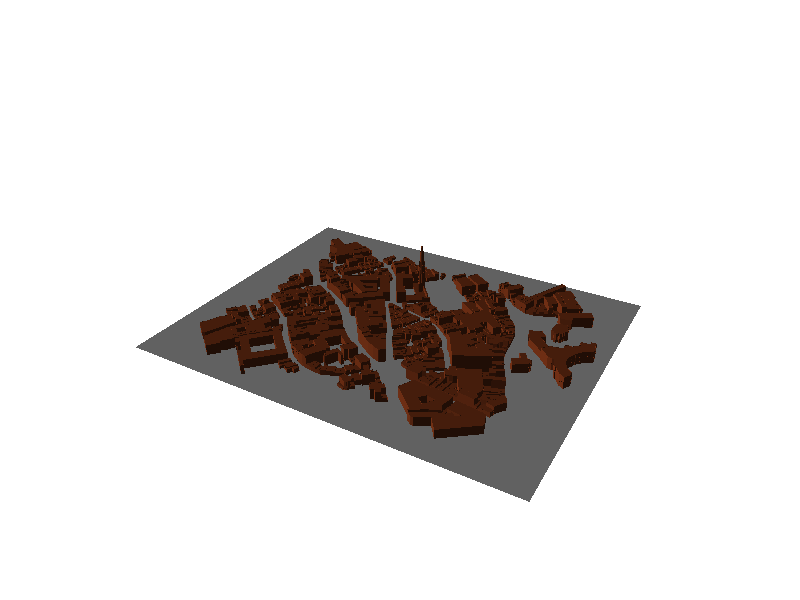

In [9]:
# TODO: load larger scene
# TODO: show example with multiple receivers
# TODO: show how to generate visibility matrix and actually use it.
# TODO: add utilities to insert to and from nodes, but with an optional "connectivity" argument?
# TODO: create an "AlmostCompleteGraph" that specializes to the exception of "from" and "to" not being connected?

from differt.rt.utils import triangles_visible_from_vertices

mesh_file = "bruxelles.obj"
mesh = TriangleMesh.load_obj(mesh_file)

tx = jnp.array([-40.0, 75, 30.0])
rx = jnp.array([+20.0, 108.034, 1.50])

mesh.plot(backend="vispy")

In [10]:
mesh.num_objects  # This is the number of triangles

14206

In [11]:
from differt_core.rt.graph import CompleteGraph

graph = CompleteGraph(mesh.num_objects)

from_ = graph.num_nodes  # Index of TX in the graph
to = from_ + 1  # Index of RX in the graph
order = 2  # Number of interactions
depth = order + 2  # + 2 because we add TX and RX notes

f"{len(graph.all_paths(from_, to, depth)):.3e}"

'2.018e+08'

In [12]:
mesh = mesh.set_assume_quads(True)
mesh.num_objects  # This is now the number of quadrilaterals, exactly half the number of triangles

7103

In [13]:
graph = CompleteGraph(mesh.num_objects)

from_ = graph.num_nodes
to = from_ + 1
order = 2

f"{len(graph.all_paths(from_, to, depth)):.3e}"  # Rougly a quarter of the preview length

'5.045e+07'

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
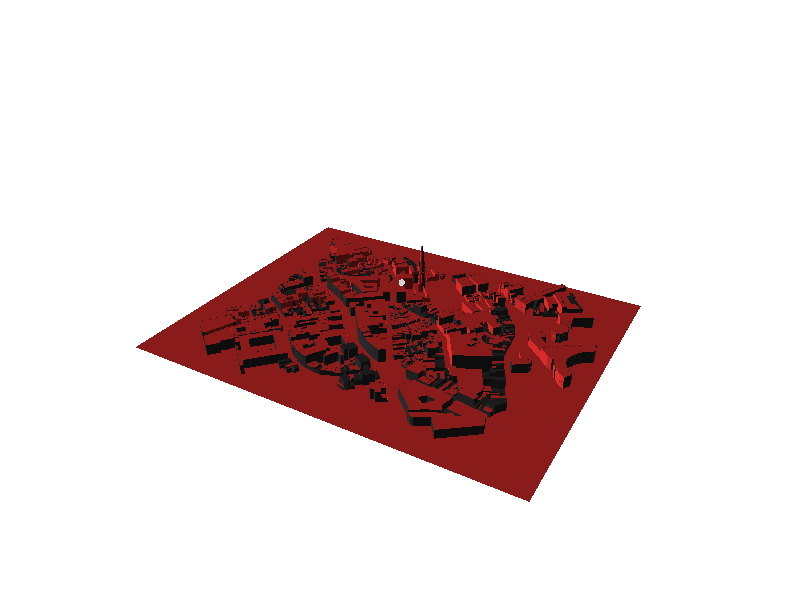

In [14]:
default_color = jnp.array([[0.2, 0.2, 0.2]])
visible_color = jnp.array([[1.0, 0.2, 0.2]])
visible_triangles = triangles_visible_from_vertices(
    tx,
    mesh.triangle_vertices,
)

mesh = mesh.set_face_colors(default_color)
mesh = mesh.set_face_colors(
    mesh.face_colors.at[visible_triangles].set(visible_color)
)

with dplt.reuse("vispy") as canvas:
    dplt.draw_markers(
        np.array([tx]), ["tx"], size=7, text_kwargs={"font_size": 2000}
    )
    mesh.plot()

canvas

In [15]:
visible_triangles.sum() / mesh.num_triangles

Array(0.33851892, dtype=float32)

In [16]:
visible_quads = visible_triangles.reshape(mesh.num_quads, 2).any(axis=-1)
visible_quads.sum() / mesh.num_quads  # ~ 44% of quadrilaterals are seen from TX

Array(0.4400957, dtype=float32)

In [17]:
from differt_core.rt.graph import CompleteGraph, DiGraph

graph = DiGraph.from_complete_graph(CompleteGraph(mesh.num_quads))
from_, to = graph.insert_from_and_to_nodes(
    from_adjacency=np.asarray(visible_quads)
)

f"{graph.all_paths(from_, to, order + 2).count():.3e}"  # ~ 44% of the previous length

'2.220e+07'